# Machine Learning 2 -Individual Assignment

# 1- IMPORTS

In [282]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score,roc_curve
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict,validation_curve


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler

from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
from pandas.core import datetools
from sklearn.decomposition import PCA
from pandas import DataFrame 
from gplearn.genetic import SymbolicTransformer
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore')
random = 111

### Functions for Data preparation

In [283]:
## Reading data 
def read_data(input_path):
    raw_data = pd.read_csv(input_path, keep_default_na=False, na_values=['_'])
    return raw_data

## fixing desired types
def fix_types(df):
    df['Work_accident'] = df['Work_accident'].astype('bool') 
    df['promotion_last_5years'] = df['promotion_last_5years'].astype('bool') 
    df['left'] = df['left'].astype('bool')
    df['sales'] = df['sales'].astype('category') 
    df['salary'] = df['salary'].astype('category') 
    df['time_spend_company']= df['time_spend_company'].astype('category')
    df['number_project']= df['number_project'].astype('category')
    return df

## one hot encoding of the desired categorical columns
def onehot_encode(df):
    category=['sales','salary']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

## Checking the features for which we will fix the skewness

def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

## Fixing the skewness of the desired features
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

## Scaling numerical features
def feature_scaling(df):
    numeric_dtypes = ['int16', 'int32', 'int64',
                          'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric_features.append(i)
    df[numeric_features]= preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(df[numeric_features])
    return df

## Get the correlation for numeric variables
def correlation_spear(df):
    numeric_dtypes = ['int16', 'int32', 'int64',
                          'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric_features.append(i)
    corr= stats.spearmanr(df[numeric_features])
    return pd.DataFrame(corr[0], columns=numeric_features,index= numeric_features)

In [1]:
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

# Functions for Feature engineering

In [284]:


## Creates a new column of total hours = time_spend_company(years)* 12 * average_montly_hours .
## and deleting the two columns in the function 
def total_hours(dataset):
    df = dataset.copy()
    df['total_hours']=df.time_spend_company * df.average_montly_hours * 12
    return df

def bin_total_hours(dataset):
    df = dataset.copy()
    bins=[0,5800,11300,13825,16680,22000]
    df['bin_total_hours']=pd.cut(dataset['total_hours'],bins)
    df = df.drop('total_hours',axis=1)
    category=['bin_total_hours']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df



## Grouping the 2,7,8,10 years in time spend in the company after analysing the graph 
## because it seems that  they behave the same towards leaving ... making the whole column as a category
def group_time(dataset):
    df=dataset.copy()
    df['time_groups']= df.time_spend_company.apply(
               lambda x: (1 if x in [2,7,8,10] else x)).astype('category')
    df = df.drop('time_spend_company',axis=1)
    category=['time_groups']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df


## Grouping the 2,6,7 projects in number of projects after analysing the graph 
## because it seems that  they behave the same towards leaving ... making the whole column as a category and then dummyfying
def group_project(dataset):
    df=dataset.copy()
    df['group_project']= df.number_project.apply(
               lambda x: (1 if x in [2,6,7] else x)).astype('category')
    df = df.drop('number_project',axis=1)
    category=['group_project']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df


## grouping the following departments because they are small and seem to behave the same
def group_depts(dataset):
    df=dataset.copy()
    to_group=['sales_product_mng','sales_RandD','sales_marketing','sales_accounting','sales_management','sales_hr']
    df['group_depts']=df.apply(lambda i : i.sales_product_mng +i.sales_RandD + i.sales_marketing+i.sales_accounting+i.sales_management +i.sales_hr, axis=1).astype('category')
    df.drop(to_group,axis=1)
    return df



### PCA will not be able to increase our accuracy only in the xase of coorelation which is not present here

def PCA_F(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numericals = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numericals.append(i)
    pca = PCA()
    data= df[numericals].copy()
    pcas = pd.DataFrame(pca.fit_transform(data))
    data = df.drop(numericals,axis=1)
    f =  pd.concat([data,pcas],axis =1 )
    return f
## Uses Genetic Programming to create new variables and add them to the dataset

def Genetic_P(dataset):
    y = dataset['left']
    X=dataset.copy()
    X=X.drop('left',axis=1)
    function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min','sin',
                 'cos',
                 'tan']
    gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=12,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=random, n_jobs=3)
    gp_features = gp.fit_transform(X,y)
    print('Number of features created out of genetic programing: {}'.format(gp_features.shape))
    new_X = pd.concat([pd.DataFrame(gp_features),dataset],axis=1)
    return new_X
    
## Bining satisfaction level after analyzing the plot
def binSatisfactionLevel(dataset):
    bins = [0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0]
    dataset['satisfaction_level_bin'] = pd.cut(dataset.satisfaction_level,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['satisfaction_level_bin'],prefix='sts', prefix_sep='_')], axis=1)
    dataset.drop('satisfaction_level', inplace=True, axis=1)
    dataset.drop('satisfaction_level_bin', inplace=True, axis=1)
    return dataset
    
    



## Creating a new column that gives back the staisfaction level of each person compared to the department they are in 
def relative_working_hours_dept(data):
    raw_data = read_data('turnover.csv')
    n  = (raw_data.groupby(['sales'], as_index=False).mean()
                .groupby('sales')['average_montly_hours'].mean())
    m = (raw_data.groupby(['sales'], as_index=True).std()['average_montly_hours'])
    df = raw_data.join(n, on='sales',rsuffix='_average').join(m, on='sales',rsuffix='_std')
    df.eval("relative_average_montly_hours = (average_montly_hours - average_montly_hours_average) /average_montly_hours_std",inplace=True)
    new  = pd.concat([data, df['relative_average_montly_hours']], axis=1).copy()
    return new



def relative_last_evaluation_dept(data):
    raw_data = read_data('turnover.csv')
    n  = (raw_data.groupby(['sales'], as_index=False).mean()
                .groupby('sales')['last_evaluation'].mean())
    m = (raw_data.groupby(['sales'], as_index=True).std()['last_evaluation'])
    df = raw_data.join(n, on='sales',rsuffix='_average').join(m, on='sales',rsuffix='_std')
    df.eval("relative_last_evaluation = (last_evaluation - last_evaluation_average) /last_evaluation_std",inplace=True)
    new  = pd.concat([data, df['relative_last_evaluation']], axis=1).copy()
    return new

def relative_satisfaction_dept(data):
    raw_data = read_data('turnover.csv')
    n  = (raw_data.groupby(['sales'], as_index=False).mean()
                .groupby('sales')['satisfaction_level'].mean())
    m = (raw_data.groupby(['sales'], as_index=True).std()['satisfaction_level'])
    df = raw_data.join(n, on='sales',rsuffix='_average').join(m, on='sales',rsuffix='_std')
    df.eval("relative_satisfaction = (satisfaction_level - satisfaction_level_average) / satisfaction_level_std",inplace=True)
    new  = pd.concat([data, df['relative_satisfaction']], axis=1).copy()
    return new

def binRelativeAvgHrs(dataset):
    bins = [-1.53,-0.77,0.59,1.8,2.4]
    dataset['relative_average_montly_hours_bin'] = pd.cut(dataset.relative_average_montly_hours,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['relative_average_montly_hours_bin'],prefix='rmhb', prefix_sep='_')], axis=1)
    dataset.drop('relative_average_montly_hours', inplace=True, axis=1)
    dataset.drop('relative_average_montly_hours_bin', inplace=True, axis=1)
    return dataset

def binRelativeSatLevel(dataset):
    bins = [-1.94, -1.05, -0.53, 0.42, 0.9, 1.28]
    dataset['Relative_satisfaction_level_bin'] = pd.cut(dataset.relative_satisfaction,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['Relative_satisfaction_level_bin'],prefix='rstl', prefix_sep='_')], axis=1)
    dataset.drop('relative_satisfaction', inplace=True, axis=1)
    dataset.drop('Relative_satisfaction_level_bin', inplace=True, axis=1)
    return dataset

def binRelativeLastEval(dataset):
    bins = [-1.64, -0.8, 0.58, 1.74]
    dataset['relative_last_evaluation_level_bin'] = pd.cut(dataset.relative_last_evaluation,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['relative_last_evaluation_level_bin'],prefix='rlel', prefix_sep='_')], axis=1)
    dataset.drop('relative_last_evaluation', inplace=True, axis=1)
    dataset.drop('relative_last_evaluation_level_bin', inplace=True, axis=1)
    return dataset






# Functions to apply the model , pipeline and CV

In [285]:
##Functions for the pipeline 


def my_log(dataset):
    target='left'
    X = dataset.loc[:, dataset.columns != target]
    y = dataset.loc[:, target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=random)
    logreg = LogisticRegression(solver='lbfgs',max_iter=250)
    L = logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    ##print('Accuracy on test: {:.2f}'.format(logreg.score(X_test, y_test)))
    ##print(confusion_matrix(y_test, y_pred))
    ##print(classification_report(y_test, y_pred))
    return logreg.score(X_test, y_test), L 

def cv_evaluate(df, splits=10):
    logreg = LogisticRegression(solver='lbfgs',max_iter=250)
    kfolds = KFold(n_splits=splits, shuffle=True, random_state=random)

    X = df.drop(['left'],axis=1)
    y = df.loc[:, 'left']
    benchmark_model = make_pipeline( logreg).fit(X=X, y=y)
    scores = cross_val_score(benchmark_model, X, y, scoring='accuracy', cv=kfolds)
    
    return scores



def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score  = np.mean(cv_evaluate(raw_data))
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score  = np.mean(cv_evaluate(processed_data))
        print('- New mean Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > -0.01:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions , engineered_data 

## This function gives you the best score from the K fold cross validation and the corresponding trained model

def get_best_fit(X_train, y_train, K=5):

    kf = KFold(n_splits=K, shuffle=True, random_state=random)

    old_Kscore=0
    accuracy = []
    k=0
    for train_index, val_index in kf.split(X_train, y_train):
        k+=1
        X_tra, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tra, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # instantiate model
        logreg = LogisticRegression(solver='lbfgs',max_iter=250)
        
        #calculate errors
        L = logreg.fit(X_tra, y_tra)
        y_pred = logreg.predict(X_val)
        Kscore = logreg.score(X_val, y_val)
    
        difference = (Kscore-old_Kscore)
        print('[diff: {:.4f}] '.format(Kscore), end='')
        if Kscore > old_Kscore:
            L_fit = L
            old_Kscore = Kscore.copy()
            b_k= k
            print('changed')
            accuracy.append(Kscore)
    print('The highest accuracy score from the K_folds obtained at K: {:.3f} id {:.3f}'.format(b_k,old_Kscore))
    return Kscore, L_fit



# Data Loading

In [286]:
raw_data = read_data('turnover.csv')
prepared = fix_skewness(fix_types((raw_data).copy()))
print('Original shape before onehot encoding: {}'.format(prepared.shape))

Original shape before onehot encoding: (14999, 10)


In [287]:
prepared.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

# Data Preparation 

In [288]:
dataset = onehot_encode(prepared)
print('Dataset shape AFTER onehot encoding: {}'.format(dataset.shape))

Dataset shape AFTER onehot encoding: (14999, 21)


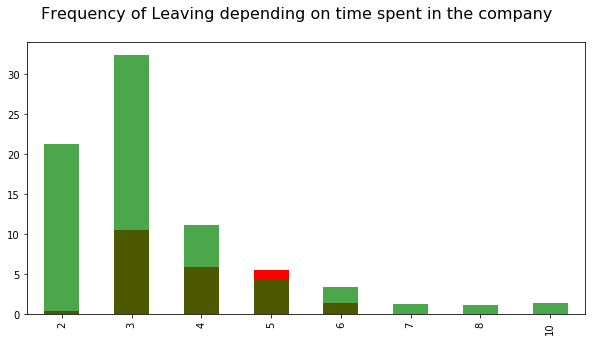

In [289]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Frequency of Leaving depending on time spent in the company', fontsize=16)
((dataset[dataset.left==1].time_spend_company.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='r')
((dataset[dataset.left==0].time_spend_company.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='g',alpha=0.7)
plt.show()

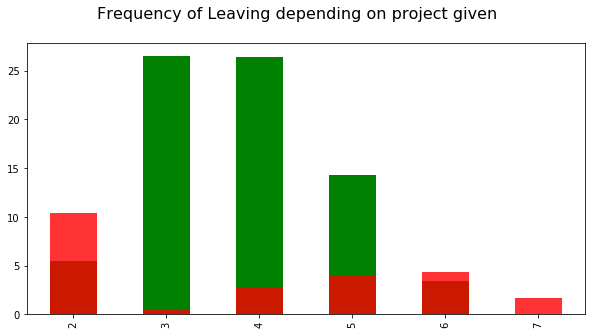

In [290]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Frequency of Leaving depending on project given', fontsize=16)
((dataset[dataset.left==0].number_project.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='g')
((dataset[dataset.left==1].number_project.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='r',alpha=0.8)
plt.show()

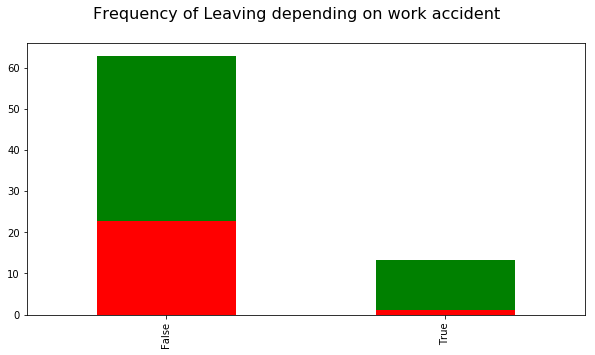

In [291]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Frequency of Leaving depending on work accident', fontsize=16)
((dataset[dataset.left==0].Work_accident.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='g')
((dataset[dataset.left==1].Work_accident.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='r',alpha=1)
plt.show()

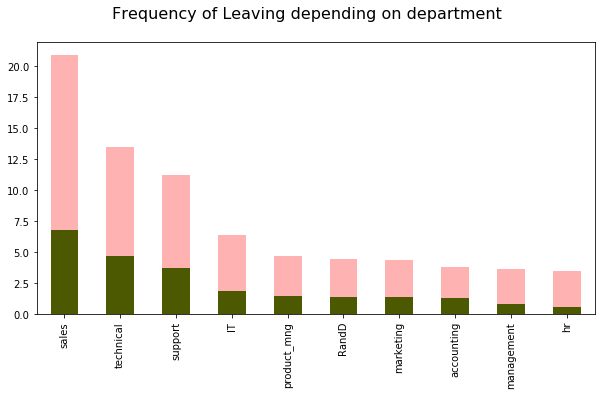

In [292]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Frequency of Leaving depending on department', fontsize=16)
((raw_data[raw_data.left==1].sales.value_counts()/len(raw_data.left))*100).plot(kind='bar',color='g')
((raw_data[raw_data.left==0].sales.value_counts()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha=0.3)
plt.show()

In [293]:
Test = total_hours(relative_working_hours(relative_satisfaction_dept(relative_last_evaluation(prepared))))

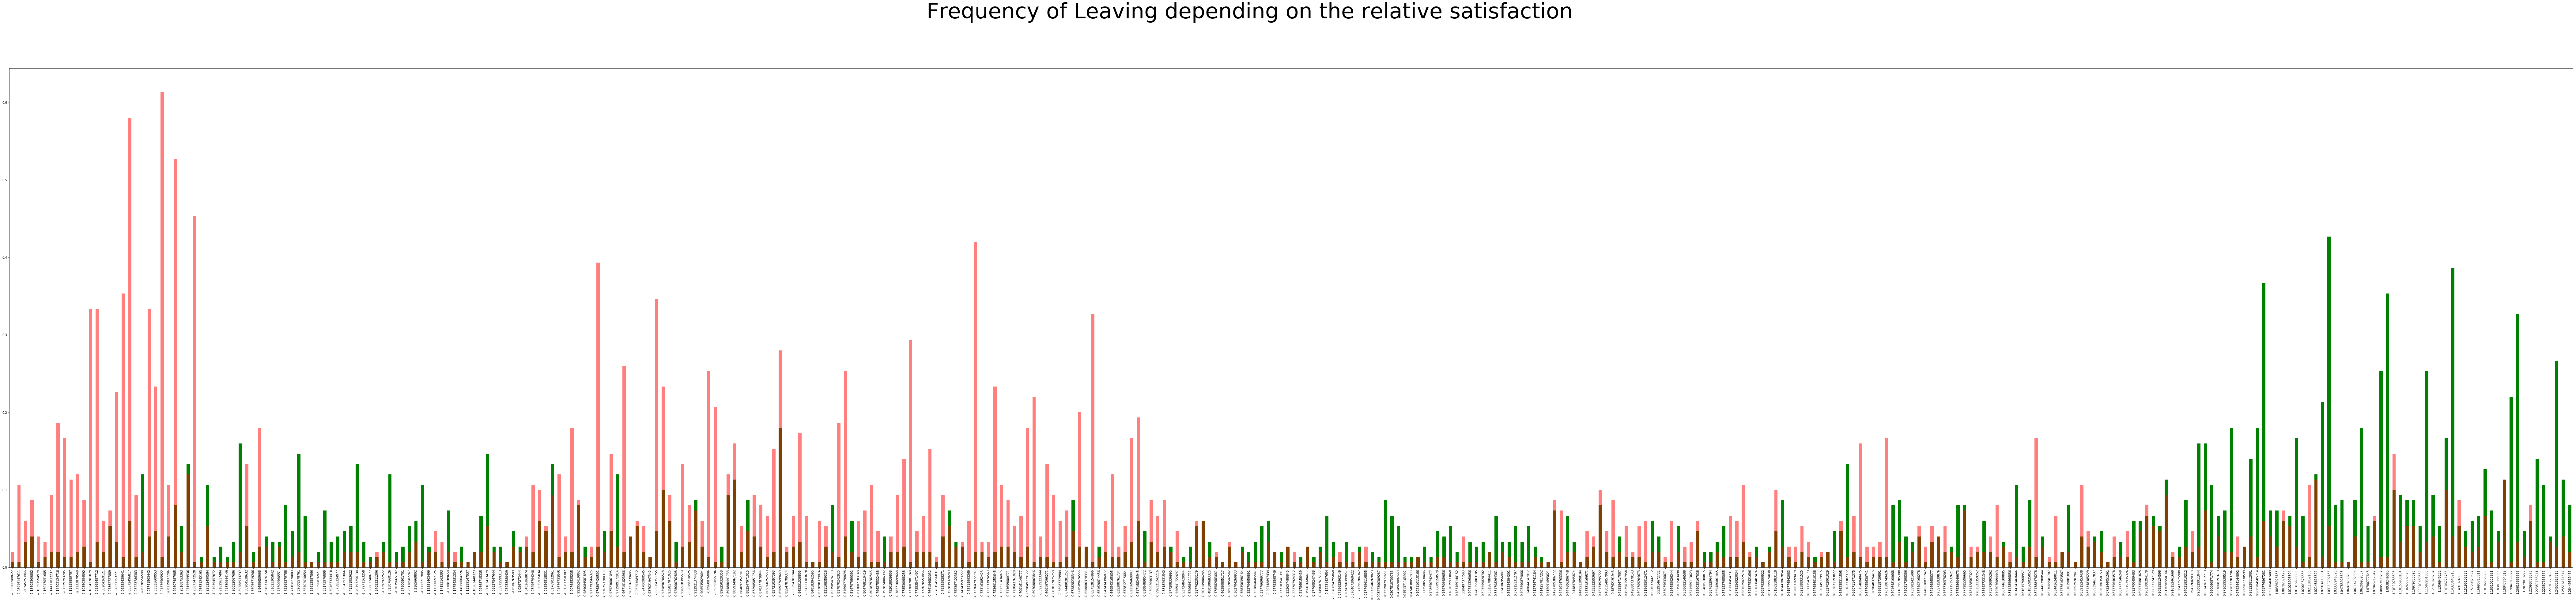

In [294]:
fig = plt.figure(figsize=(150,30))
fig.suptitle('Frequency of Leaving depending on the relative satisfaction', fontsize=70)
((Test[Test.left==0].relative_satisfaction.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='g')
((Test[Test.left==1].relative_satisfaction.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='r',alpha=0.5)
plt.show()

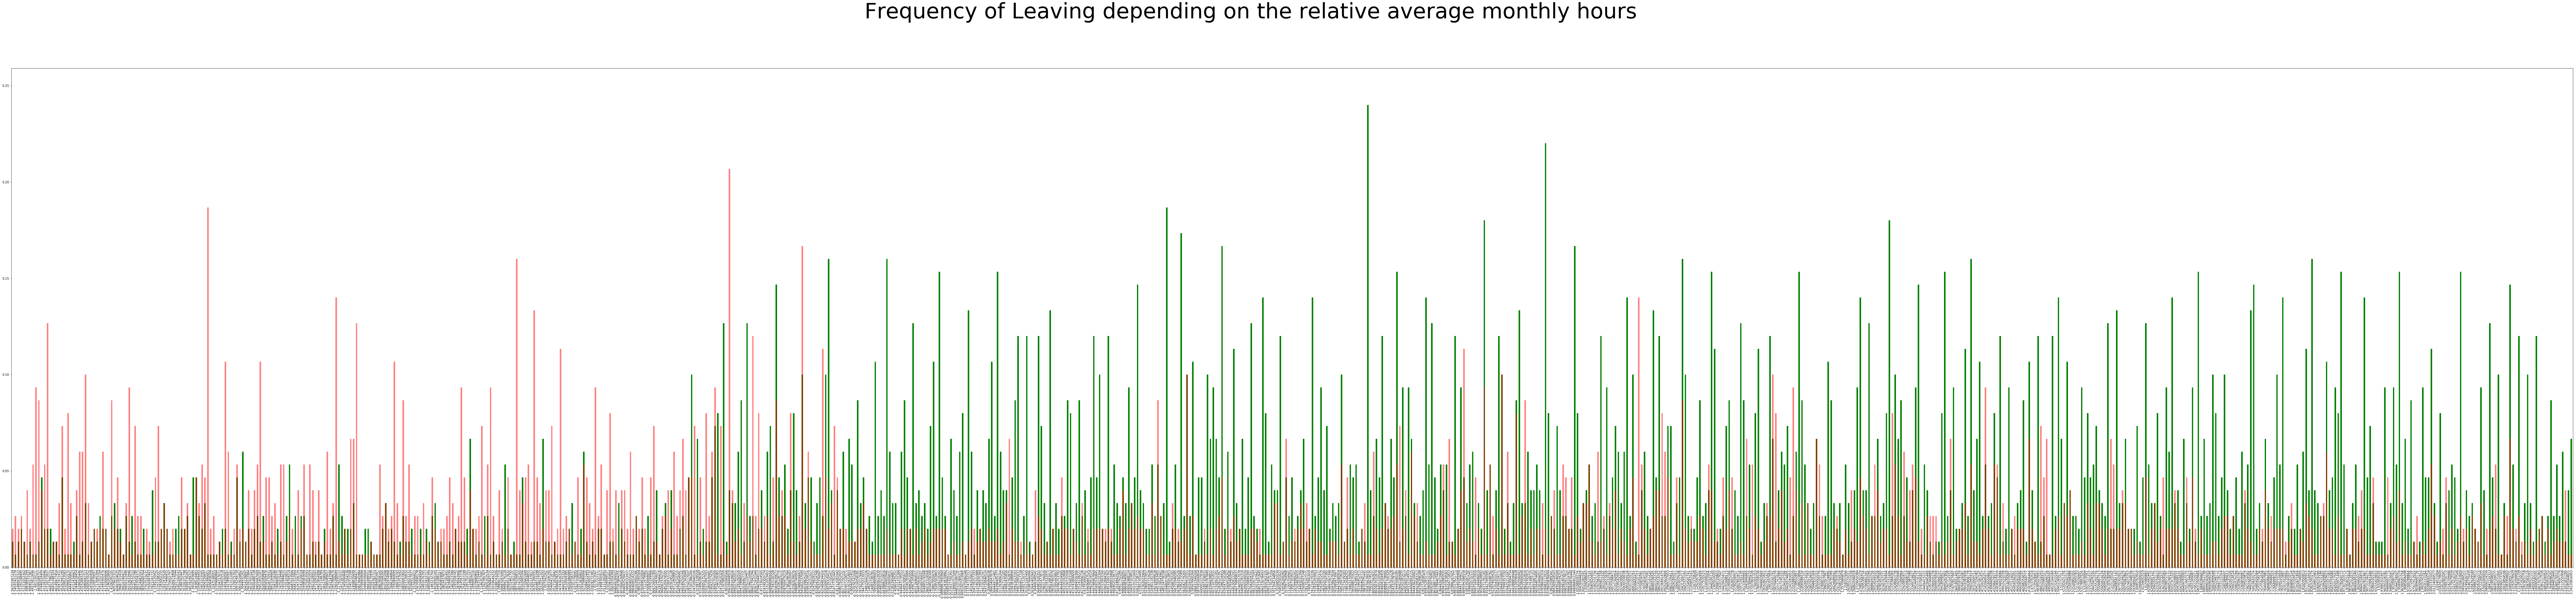

In [295]:
fig = plt.figure(figsize=(150,30))
fig.suptitle('Frequency of Leaving depending on the relative average monthly hours', fontsize=70)
((Test[Test.left==0].relative_average_montly_hours.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='g')
((Test[Test.left==1].relative_average_montly_hours.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='r',alpha=0.5)
plt.show()

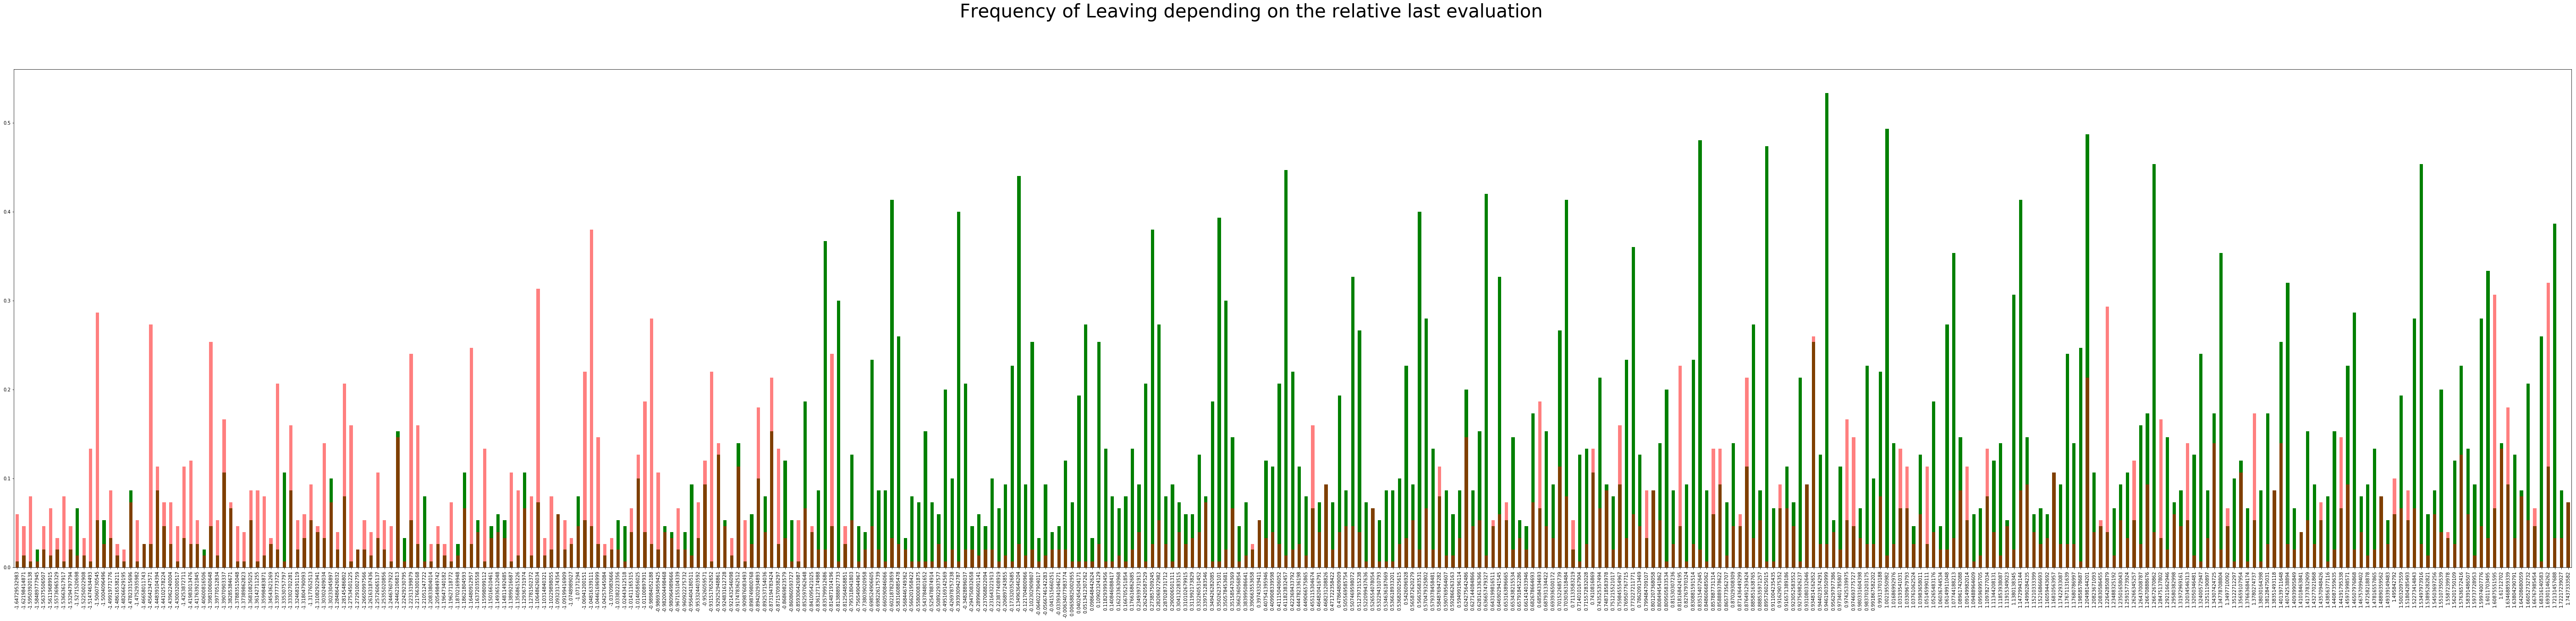

In [296]:
fig = plt.figure(figsize=(100,20))
fig.suptitle('Frequency of Leaving depending on the relative last evaluation', fontsize=40)
((Test[Test.left==0].relative_last_evaluation.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='g')
((Test[Test.left==1].relative_last_evaluation.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='r',alpha=0.5)
plt.show()

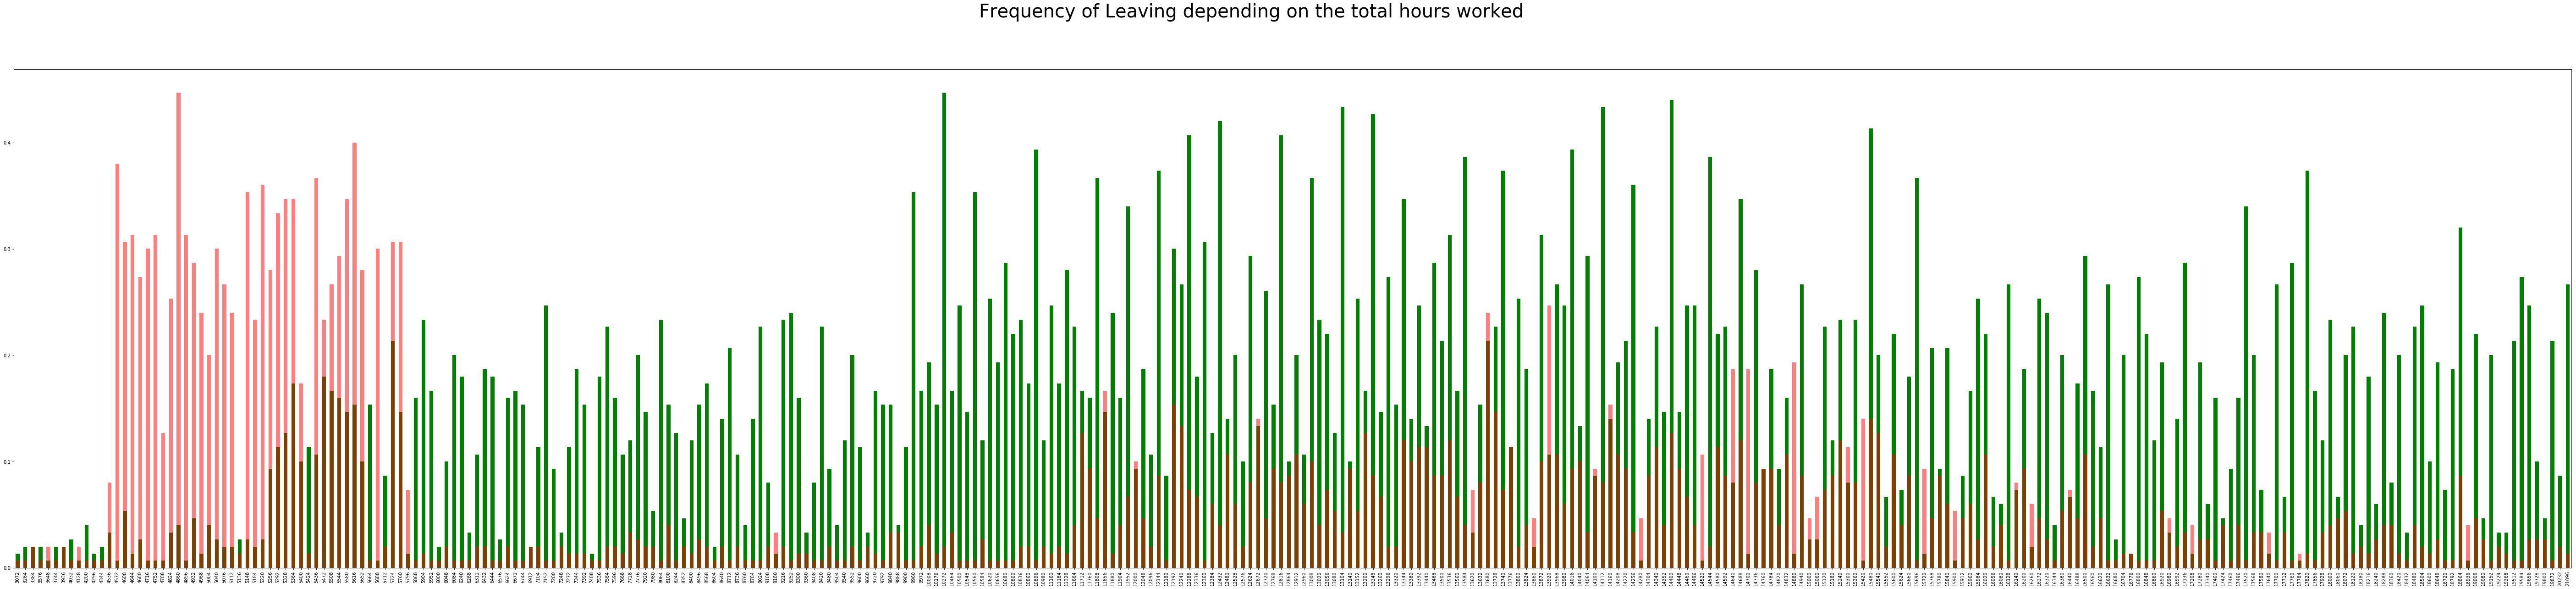

In [297]:
fig = plt.figure(figsize=(100,20))
fig.suptitle('Frequency of Leaving depending on the total hours worked', fontsize=40)
(pd.Series((Test[Test.left==0].total_hours.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='g'),
(pd.Series((Test[Test.left==1].total_hours.value_counts().sort_index()/len(Test.left))*100).plot(kind='bar',color='r',alpha=0.5)))
plt.show()

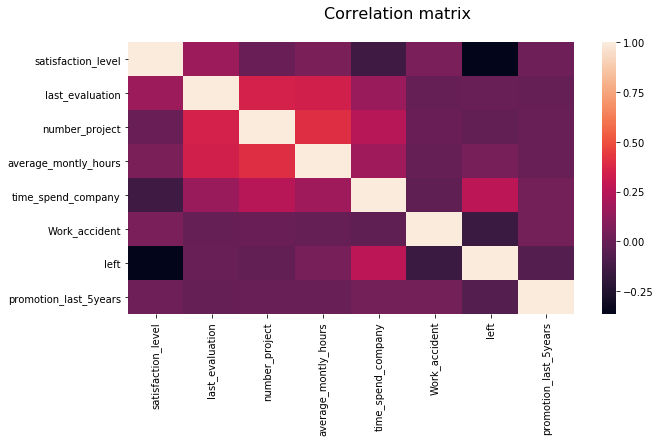

In [298]:
corr = correlation_spear(raw_data)
fig = plt.figure(figsize=(10,5))
fig.suptitle('Correlation matrix', fontsize=16)
sns.heatmap(corr)

# Baseline Model 

In [299]:
## Applying a logistic regression on the initial dataset taking a simple 
## 80/20 split 

score = my_log(dataset)
print('My baseline score is: {}'.format(score[0]))

My baseline score is: 0.795


# Feature Engineering

In [300]:
fe_functions=['relative_satisfaction_dept',
              'relative_working_hours_dept',
              'relative_last_evaluation_dept',
              'total_hours',
              'bin_total_hours',
              'binRelativeAvgHrs',
              'binRelativeSatLevel',
              'binRelativeLastEval',
              'group_time',
              'binSatisfactionLevel',
              'group_depts',
              'group_project',
              'feature_normalizing',
             'Genetic_P',
             'PCA_F']

sf , ND= feature_engineering_pipeline(dataset, fe_functions)
print('Dataset shape AFTER feature engineering: {}'.format(ND.shape))

Base Score: 0.7915
- New mean Score (relative_satisfaction_dept): 0.7901 [diff: -0.0014] [Accepted]
- New mean Score (relative_working_hours_dept): 0.7919 [diff: 0.0018] [Accepted]
- New mean Score (relative_last_evaluation_dept): 0.7917 [diff: -0.0002] [Accepted]
- New mean Score (total_hours): 0.7912 [diff: -0.0005] [Accepted]
- New mean Score (bin_total_hours): 0.8787 [diff: 0.0875] [Accepted]
- New mean Score (binRelativeAvgHrs): 0.8961 [diff: 0.0174] [Accepted]
- New mean Score (binRelativeSatLevel): 0.9301 [diff: 0.0340] [Accepted]
- New mean Score (binRelativeLastEval): 0.9386 [diff: 0.0085] [Accepted]
- New mean Score (group_time): 0.9473 [diff: 0.0087] [Accepted]
- New mean Score (binSatisfactionLevel): 0.9610 [diff: 0.0137] [Accepted]
- New mean Score (group_depts): 0.9607 [diff: -0.0003] [Accepted]
- New mean Score (group_project): 0.9623 [diff: 0.0016] [Accepted]
- New mean Score (feature_normalizing): 0.9622 [diff: -0.0001] [Accepted]
    |    Population Average   |       

Selected features: ['rmhb_(1.8, 2.4]', 'salary_high', 'sales_IT', 'bin_total_hours_(16680, 22000]', 'promotion_last_5years', 'time_groups_4', 'sts_(0.92, 1.0]', 'sts_(0.11, 0.35]', 'time_groups_5', 'sts_(0.46, 0.71]', 'bin_total_hours_(0, 5800]', 'left', 'rstl_(-1.94, -1.05]', 'rmhb_(0.59, 1.8]', 'sales_marketing', 'time_groups_1', 'group_depts', 'sales_RandD', 'group_project_1', 'group_project_5', 0, 1, 2, 5, 6, 7, 9, 10, 11, 12]
Optimal number of features : 30


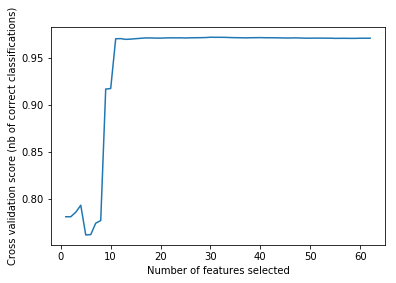

In [302]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
kf = KFold(n_splits=10, shuffle=True, random_state=random)
X = ND.loc[:, ND.columns != 'left']
y = ND.loc[:, target]

logreg = LogisticRegression(solver='lbfgs', max_iter=250,random_state=random)
rfe = RFECV(logreg, cv =kf,scoring='accuracy')
rfe = rfe.fit(X, y)

Selected_Features = list(ND.loc[:, rfe.support_])
Selected_Features.remove('left')
print('Selected features: {}'.format(list(ND.loc[:, rfe.support_])))




print("Optimal number of features : %d" % rfe.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [303]:
target='left'
X = ND.loc[:,  Selected_Features]
y = ND.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            \
                                                    test_size=0.2, 
                                                    random_state=random)
Kscore , L_fit = get_best_fit(X_train, y_train, 10)

[diff: 0.9658] changed
[diff: 0.9658] [diff: 0.9700] changed
[diff: 0.9683] [diff: 0.9725] changed
[diff: 0.9683] [diff: 0.9700] [diff: 0.9750] changed
[diff: 0.9700] [diff: 0.9725] The highest accuracy score from the K_folds obtained at K: 8.000 id 0.975


In [304]:
final_score = L_fit.score(X_test,y_test)
final_score

0.97233333333333338

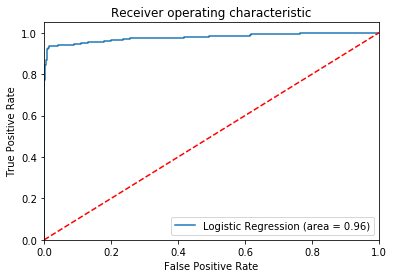

[[2246   29]
 [  54  671]]
             precision    recall  f1-score   support

      False       0.98      0.99      0.98      2275
       True       0.96      0.93      0.94       725

avg / total       0.97      0.97      0.97      3000

The final accuracy score is : 0.9723333333333334


In [309]:
y_pred = L_fit.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, L_fit.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('The final accuracy score is : {}' .format(final_score))